In [1]:
import numpy as np
import pandas as pd
import xarray as xr
# import GPy
import geopandas
import os, shutil, time, pdb, random
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *

from elbo import *

# from shapely.geometry import box, mapping
import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set_theme()
pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rc_file_defaults()

In [2]:
from plum import dispatch
from varz.torch import Vars
import torch.nn as nn
import torch
from stheno.torch import B, GP, EQ, Normal, Measure
from matrix import Diagonal
import numpy as np


# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
import matplotlib.pyplot as plt

In [3]:
# Import Beas and Sutlej shapefiles
beas_shp = '/Users/marron31/Google Drive/PhD/gis/exports/beas_watershed.shp'
sutlej_shp = '/Users/marron31/Google Drive/PhD/gis/exports/sutlej_watershed.shp'

beas = geopandas.read_file(beas_shp)
sutlej = geopandas.read_file(sutlej_shp)

catchments = beas.append(sutlej)

In [4]:
# Let all of Stheno run on that device.
B.device(device).__enter__()

B.epsilon = 1e-1  # Needs to be relatively high for `float32`s

In [5]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

In [6]:
predictant = ['Prec']
predictors = [#'Date',
              #'Station',
              #'Prec',
              #'Corrected Station Name', 
              'X', 'Y',
              #'Altitude (m)', 
              'Z', 
              'wrf_prcp', #'wrf_bc_prcp', 
              #'elev_hr', 
              #'aspect','slope', 
              #'doy', 
              'doy_sin', 'doy_cos', 
              #'wrf_prcp_-1', 'wrf_prcp_-2','wrf_prcp_1', 'wrf_prcp_2', 
              #'Basin', 'lon', 'lat', 
              #'era5_u', 'era5_v',
              #'era5_u_-2', 'era5_u_-1', 'era5_u_1', 'era5_u_2', 
              #'era5_v_-2', 'era5_v_-1', 'era5_v_1', 'era5_v_2'
             ]

In [7]:
root_folder = '../../PhD/data/SUSHIWAT/ready'

class UpperIndusGridDataset(Dataset):
    """Grid data for the Beas and Sutlej basins of the Upper Indus region"""
    
    def __init__(self, root_folder, train_mean, train_var):
        
        self.train_mean = np.expand_dims(train_mean, 1)
        self.train_var = np.expand_dims(train_var, 1)
        
        self.srtm = xr.open_dataset(os.path.join(root_folder,'srtm_reprojected_beas.nc'))
        self.era5_u = xr.open_dataset(os.path.join(root_folder,'era5_u_reprojected.nc'))
        self.era5_v = xr.open_dataset(os.path.join(root_folder,'era5_v_reprojected.nc'))
        self.wrf = xr.open_dataset(os.path.join(root_folder,'wrf.nc'))
        
        self.doy = pd.DatetimeIndex(self.wrf.time.values).dayofyear
        
        self.doysin = np.sin(self.doy*2*pi/365)
        self.doycos = np.cos(self.doy*2*pi/365)
        
        self.n = len(self.wrf.time)
        
    def __len__(self):
        return self.n
    def __getitem__(self,idx):
        
        srtm_arr = self.srtm.z.values.squeeze().flatten()
        mask = np.where(srtm_arr > 0)[0]
        
        wrf_arr = self.wrf.model_precipitation.isel(time=idx).values.flatten()
        
        #era5_u_arr = self.era5_u.u.isel(time=idx).values.flatten()
        #era5_v_arr = self.era5_v.v.isel(time=idx).values.flatten()
        
        x_arr, y_arr = np.meshgrid(self.srtm.x, self.srtm.y)
        x_arr, y_arr = x_arr.flatten(), y_arr.flatten()
        
        doysin_arr = np.full(x_arr.shape,self.doysin[idx]).flatten()
        doycos_arr = np.full(x_arr.shape,self.doycos[idx]).flatten()
        
#          print(srtm_arr.shape, wrf_arr.shape, x_arr.shape, y_arr.shape, doysin_arr.shape, doycos_arr.shape)
        
        array = np.stack([x_arr, y_arr, srtm_arr, wrf_arr, doysin_arr, doycos_arr
                         #era5_u_arr, era5_v_arr
                        ])[:,mask] 
        
        array_norm = (array - self.train_mean) / np.sqrt(self.train_var)
        
        return array_norm, array

In [8]:
def prepare_data(TRAIN_PATH, start, end):
    
    st = (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
    .pipe(clip_time_period, start, end) # Clip data temporally
    )
    
    st[st['Basin']=='Beas']
    
    n = len(st)

    st.set_index(['Date','Station'], inplace=True)
    st = st[predictant + predictors]

    mean = st[predictors].mean().values
    var = st[predictors].var().values

    st[predictors] = (st[predictors] - mean) / np.sqrt(var)

    st = st.unstack(1).stack(1, dropna=False)
    st['X'] = st.groupby("Station")['X'].transform('mean')
    st['Y'] = st.groupby("Station")['Y'].transform('mean')
    
    return st, n, mean, var

In [9]:
class UpperIndusDataset(Dataset):
    """Station data for the Beas and Sutlej basins of the Upper Indus region"""
    def __init__(self, TRAIN_PATH):
        st, n, mean, var = prepare_data(TRAIN_PATH, start, end)
        self.st = st
        self.ds = st.to_xarray()
        self.n = n
        
        self.mean = mean
        self.var = var
        
    def __len__(self):
        return len(self.ds.Date)
    def __getitem__(self,idx):
        arr = self.ds.isel(Date=idx).to_array().values
        return arr[1:,:], arr[0,:]

In [10]:
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [11]:
ds_dataset = UpperIndusDataset(TRAIN_PATH)

train_mean = ds_dataset.mean
train_var = ds_dataset.var

dataloader = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)

train_dataloader = validation_dataloader = dataloader

In [12]:
def forward_backward_pass(inputs, labels, n, inducing_points=True, backward=True, f_marginal=True, n_samples=10):
    
    b = inputs.shape[0] # mini batch size

    # Build MV Normal Distribution
    q.build_normal()

    # GP inputs 
    x = inputs[0,:2,:].permute(1,0).float()

    # Compute KL
    if inducing_points:
        f_post = f | (f(x_ind), q.sample())
        kl = q.kl(f(x_ind))
    else:
        f_x = f(x)
        kl = q.kl(f_x)
    
    # Repeat input tensor K times
    inputs = inputs[:,2:,:].unsqueeze(-1).repeat(1,1,1,n_samples).permute(0,2,3,1)
    labels = labels.unsqueeze(-1).repeat(1,1,n_samples)
    
    # Sample z and concatenate to inputs
    if inducing_points:
        if f_marginal:
            f_sample = Normal(f_post.mean(x),
                              Diagonal(f_post.kernel.elwise(x)[:, 0])
                             ).sample(b*n_samples)     
        else:
            f_sample = f_post(x).sample(b*n_samples)
                
        f_sample = f_sample.permute(1,0).unsqueeze(1).reshape(b,-1,x.shape[0],n_samples).permute(0,2,3,1)
        inputs = torch.cat([f_sample, inputs], dim=3)

    else:
        q_sample = q.sample(b).permute(1,0).unsqueeze(1)
        inputs = torch.cat([q_sample, inputs], dim=1)

    # Masking for missing data
    
    #inputs = inputs.permute(0,1,3,2)
    mask = ~torch.any(inputs.isnan(),dim=3)
    
    k = mask.sum()

    # Forward pass
    outputs = model(inputs[mask].float())
    
    # Reconstruction term  
    recon = -loss_fn(outputs, labels[mask], model, reduction='sum') # Check if this is biased

    # ELBO
    elbo = recon/(b*k) - kl/n # OR (n/(b*k)*recon - kl)/n

    # Backward pass and optimizer step
    if backward:
        (-elbo).backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return elbo, recon, kl, k

In [13]:
model = MLP(in_channels=5, #len(predictors)+1, 
            hidden_channels=[10], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
            linear_model=False
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 93


In [14]:
print_progress = True
plot_x_ind = False
validate_flag = False

In [15]:
arr, _ = UpperIndusGridDataset(root_folder, train_mean, train_var).__getitem__(10)

x_min = arr[0,:].min()
x_max = arr[0,:].max() 
y_min = arr[1,:].min()
y_max = arr[1,:].max()

In [17]:
st = ds_dataset.st

x_ind_stations = st.groupby('Station').mean()[['X','Y']].values
x_ind_stations.shape

(58, 2)

In [18]:
x_points = 10
y_points = 10

grid = np.meshgrid(np.linspace(st['X'].min(),st['X'].max(),x_points),np.linspace(st['Y'].min(),st['Y'].max(),y_points))
# grid = np.meshgrid(np.linspace(x_min,x_max,x_points),np.linspace(y_min,y_max,y_points))

grid = torch.tensor(grid, dtype=torch.float32).flatten(start_dim=1).permute(1,0)

# x_ind = grid.clone().detach().requires_grad_(True) 
# num_ind_points = x_points * y_points

x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False)
num_ind_points = len(x_ind)

n = len(st)

train_loss, train_loglik, train_kl = [], [], []
val_loss, val_loglik, val_kl = [], [], []
test_loss, test_loglik, test_kl = [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch = RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch = RunningAverage(), RunningAverage(), RunningAverage()

# model.train()

# prior = Measure()

# with Measure() as prior:
#     f1 = GP(EQ().stretch(10))
#     f2 = GP(EQ().stretch(5))
#     f3 = GP(EQ().stretch(0.2))
#     f = f1 + f2 + f3

f = GP(EQ().stretch(0.2))
    
q = ApproximatePosterior(num_ind_points)

# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[x_ind], lr=10e-3)
optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters()), lr=10e-3)

num_epochs = 10

for e in range(num_epochs):
    
    # TRAIN EPOCH
    
    model.train()
        
    if plot_x_ind and (e % 10 == 0):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(x_ind.detach()[:,0],x_ind.detach()[:,1])
        plt.show()

    start = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()

    n = train_dataloader.dataset.n

    for i, (inputs, labels) in enumerate(train_dataloader):

        elbo, recon, kl, num_points = forward_backward_pass(inputs, labels, n, inducing_points=True, backward=True, f_marginal=True)

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item()/num_points)
        train_kl_batch.update(kl.item())

    elapsed = time.time() - start

    if print_progress:
        print(f'Average values for training epoch {e}: -elbo: {train_loss_batch.avg:.4f} | kl: {train_kl_batch.avg:.4f} | -log-lik: {train_loglik_batch.avg:.4f} -- time elapsed: {elapsed:.2f}')
    
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(train_loglik_batch.avg)
    train_kl.append(train_kl_batch.avg)
    
    # VALIDATION EPOCH
    
    if validate_flag:
        model.eval()

        n = validation_dataloader.dataset.n

        start = time.time()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(validation_dataloader):

                elbo, recon, kl, num_points = forward_backward_pass(inputs, labels, n, inducing_points=True, backward=False, f_marginal=True)

                # Keep track of loss terms
                val_loss_batch.update(-elbo.item())
                val_loglik_batch.update(-recon.item()/num_points)
                val_kl_batch.update(kl.item())

        elapsed_val = time.time() - start

        if print_progress:
            print(f'Average values for validation epoch {e}: -elbo: {np.mean(val_loss_batch):.4f} | kl: {np.mean(val_kl_batch):.4f} | -log-lik: {np.mean(val_loglik_batch):.4f} -- time elapsed: {elapsed_val:.2f}')

        val_loss.append(val_loss_batch.avg)
        val_loglik.append(val_loglik_batch.avg)
        val_kl.append(val_kl_batch.avg)

/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/lab/types.py:167: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(getattr(np, name), type):
/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/lab/types.py:172: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself.

Average values for training epoch 0: -elbo: 0.0975 | kl: 1534.1116 | -log-lik: 1.4168 -- time elapsed: 8.63
Average values for training epoch 1: -elbo: 0.0782 | kl: 625.8160 | -log-lik: 1.1935 -- time elapsed: 8.67
Average values for training epoch 2: -elbo: 0.0752 | kl: 312.6389 | -log-lik: 1.1741 -- time elapsed: 8.03
Average values for training epoch 3: -elbo: 0.0739 | kl: 174.5113 | -log-lik: 1.1644 -- time elapsed: 7.84
Average values for training epoch 4: -elbo: 0.0741 | kl: 99.9856 | -log-lik: 1.1638 -- time elapsed: 8.94
Average values for training epoch 5: -elbo: 0.0740 | kl: 57.6123 | -log-lik: 1.1634 -- time elapsed: 8.10
Average values for training epoch 6: -elbo: 0.0739 | kl: 33.7860 | -log-lik: 1.1622 -- time elapsed: 7.54
Average values for training epoch 7: -elbo: 0.0735 | kl: 20.2693 | -log-lik: 1.1606 -- time elapsed: 7.36
Average values for training epoch 8: -elbo: 0.0734 | kl: 12.6510 | -log-lik: 1.1603 -- time elapsed: 7.51
Average values for training epoch 9: -elb

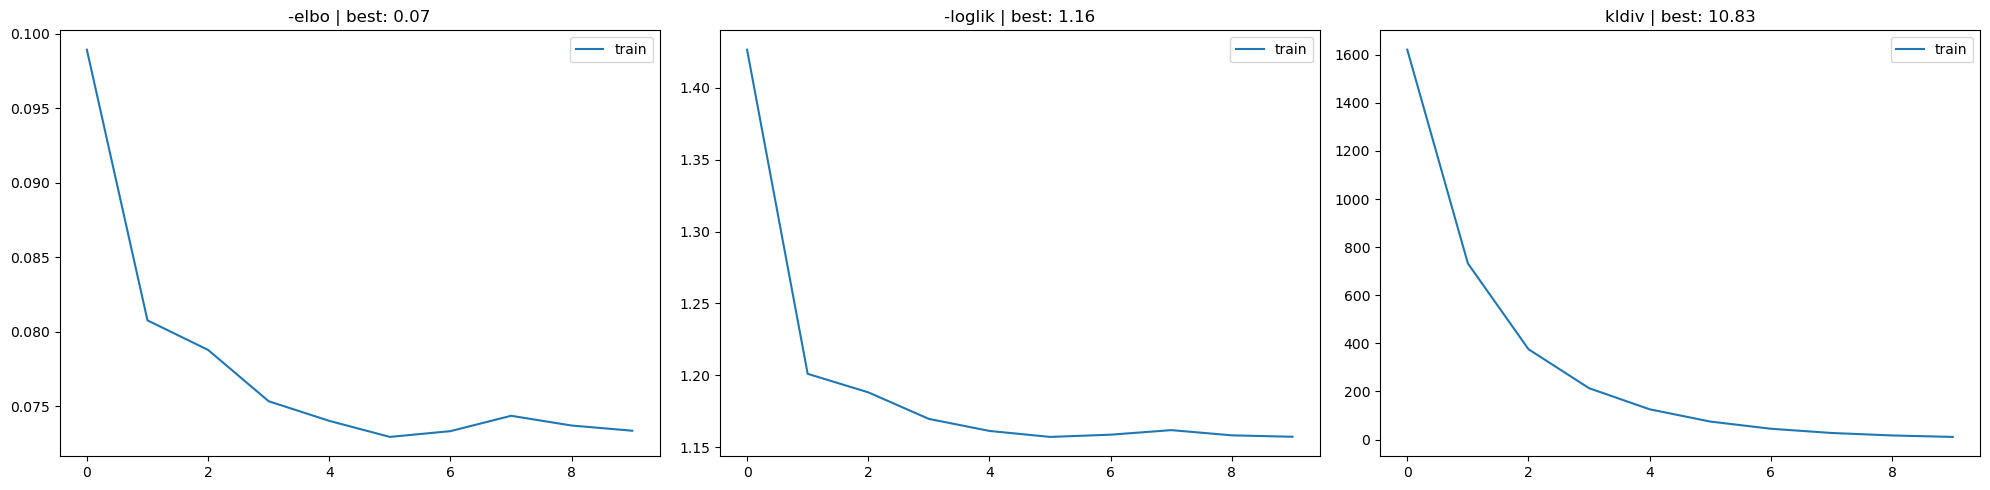

In [1652]:
train_vars = [train_loss, train_loglik, train_kl] 
validation_vars = [val_loss, val_loglik, val_kl]

labels = ['-elbo','-loglik','kldiv']

fig, axes = plt.subplots(1,3, figsize=(20,5))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
#     ax.plot(validation_vars[i], label='val')
    ax.legend()
    ax.set_title(f'{labels[i]} | best: {np.min(train_vars[i]):.2f}')
plt.tight_layout()

In [1654]:
test_dataloader = DataLoader(dataset=UpperIndusGridDataset(root_folder, train_mean, train_var), batch_size=1, shuffle=True)
inducing_points = True

model.eval()

with torch.no_grad():
    
    for index, (inputs, inputs_plot) in enumerate(test_dataloader):
        
        b = inputs.shape[0]
        
        if index == 0:
        
            q.build_normal()

            x = inputs[0,:2,:].permute(1,0).float()
            
            inputs = inputs[:,2:,:]

            # Sample z and concatenate to inputs
            if inducing_points:
                
                #f_sample = f_post(x).sample(b).permute(1,0).unsqueeze(1)
                
                f_post = f | (f(x_ind), q.sample())
                
                f_sample = Normal(
                    f_post.mean(x),
                    Diagonal(f_post.kernel.elwise(x)[:, 0])
                ).sample().permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([f_sample, inputs], dim=1)
                 
            else:
                q_sample = q.sample(b).permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([q_sample, inputs], dim=1)

            # Masking for missing data
            inputs = inputs.permute(0,2,1)
 
            mask = ~torch.any(inputs.isnan(),dim=2)
            k = mask.sum()

            # Forward pass
            outputs = model(inputs[mask].float())
            
            print('done')
        
        break

done


In [1655]:
col_names = ['X','Y','Z','wrf_prcp','doy_sin','doy_cos','GPsample','pi','alpha','beta']

data = np.concatenate([inputs_plot.squeeze().permute(1,0).numpy(),inputs[:,:,0].permute(1,0),outputs.numpy()], axis=1)

df = pd.DataFrame(data, columns=col_names)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

gdf['uniform'] = gdf.apply(lambda x: np.random.uniform(0,1),axis=1)
gdf['sample'] = gdf.apply(sample, axis=1)

gdf['uniform'] = gdf.apply(lambda x: 0.5, axis=1)
gdf['bg_median'] = gdf.apply(sample, axis=1)

gdf['g_mean'] = gdf['alpha']/gdf['beta']

gdf['p'] = 1 - gdf['pi']

x_ind_plot = x_ind.detach().numpy() * np.sqrt(train_var[:2]) + train_mean[:2] 

In [1656]:
st_stations = st.groupby('Station').mean()[['X','Y']] * np.sqrt(train_var[:2]) + train_mean[:2]

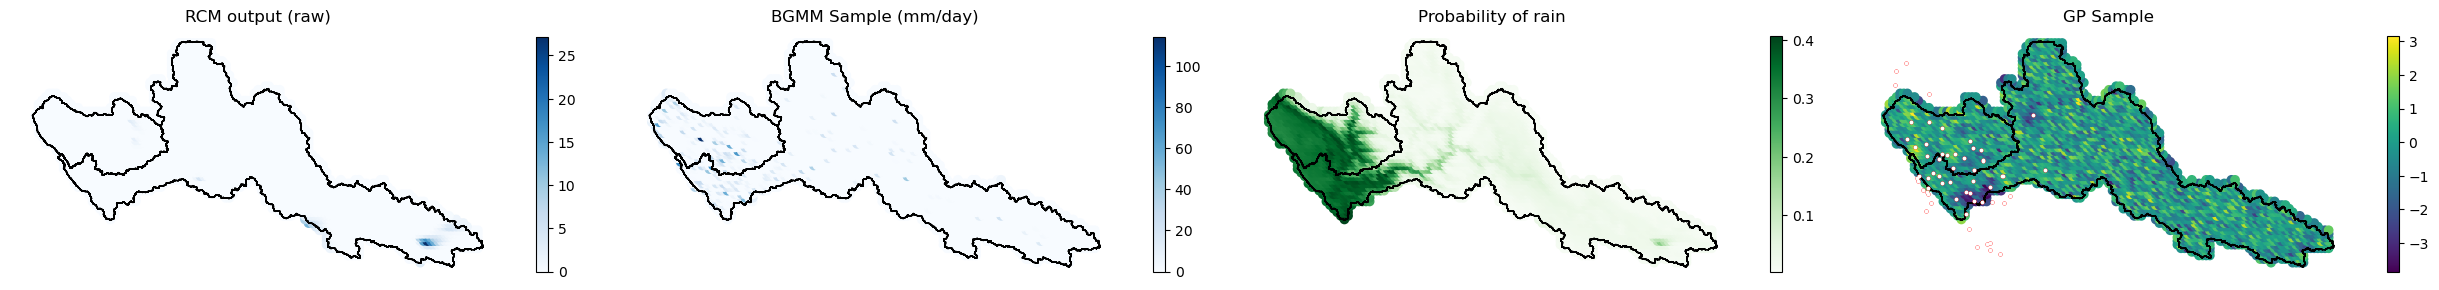

In [1657]:
variables = ['wrf_prcp','sample',
             'p',
             #'g_mean',
             #'bg_median',
             #'Z',
             'GPsample']

labels = ['RCM output (raw)', 
          'BGMM Sample (mm/day)', 
          'Probability of rain',
          #'BGMM Mean (slab component) (mm/day)',
          #'BGMM Median (mm/day)',
          #'Elevation (m.a.s.l.)',
          'GP Sample']

cmaps = ['Blues',
         'Blues',
         'Greens',
         #'Blues',
         #'Blues',
         #'terrain',
         'viridis']

fig, axes = plt.subplots(1,4,figsize=(25,5))

for idx, ax in enumerate(axes.flatten()):
    
    if idx < len(variables):
    
    #     gdf.set_crs(catchments.crs)
    #     gdf_clip = geopandas.clip(gdf, catchments)
    
        gdf.plot(variables[idx], ax=ax, legend=True, cmap=cmaps[idx], legend_kwds={'shrink': 0.5})
        beas.plot(ax=ax, facecolor='None', edgecolor='black')
        sutlej.plot(ax=ax, facecolor='None', edgecolor='black')

        ax.set_title(labels[idx])
        
        if variables[idx]=='GPsample':
            ax.scatter(x_ind_plot[:,0],x_ind_plot[:,1], s=4, c='r')
            ax.scatter(st_stations['X'],st_stations['Y'], s=3, c='w')

    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_xticks([])     

plt.tight_layout()